In [1]:
import numpy as np
from esis.data import level_3
import matplotlib.pyplot as plt
import scipy.ndimage
from esis.data.inversion import mart
import astropy.units as u
import kgpy.img.coalignment.image_coalignment as kgpy_img
from kgpy.plot import hypercube_slicer
import astropy.wcs as wcs

%reload_ext autoreload
%autoreload 2
%matplotlib notebook




# plt.rcParams['figure.figsize'] = [20, 20]

# ESIS Level 3 O V Inversion w/ MART

Previous to this inversion attempt a Level 3 data product was prepared for the primary O V spectral line observed by
ESIS during the Sept 30th 2020 launch from WSMR.  The raw data has been taken to Level1 and despiked.  Then the Level 1
data was converted to Level 3 through a linear co-alignment to AIA 304, an updated internal alignment using a quadratic
coordinate transform, a fit and correction of the vignetting, and normalized by a image mean taken from a section of 
image not contaminated by the brightest Mg X line (and shared by each camera) using a combined mask.  Details of the 
build exist in ov_Level_3.ipynb.  


In [2]:

ov = level_3.Level3.from_pickle(level_3.ov_final_path)
seq = 0
# event = [slice(None),slice(None)]
event = [slice(80,1120),slice(80,1120)]
pad = 0

region = ov.observation.data[seq,:,event[0],event[1]]/2

x,y = kgpy_img.get_img_coords(region[0])
x0,y0 = [region.shape[-2] // 2, region.shape[-1] //2]
len_scl = min(region.shape[-1],region.shape[-2])/2.5
print(len_scl)
window = np.exp(-(np.sqrt(np.square(x-x0) + np.square(y-y0))/len_scl)**(6))
window=window.T
# window = np.ones_like(region[0])

416.0


Build Guess

<IPython.core.display.Javascript object>


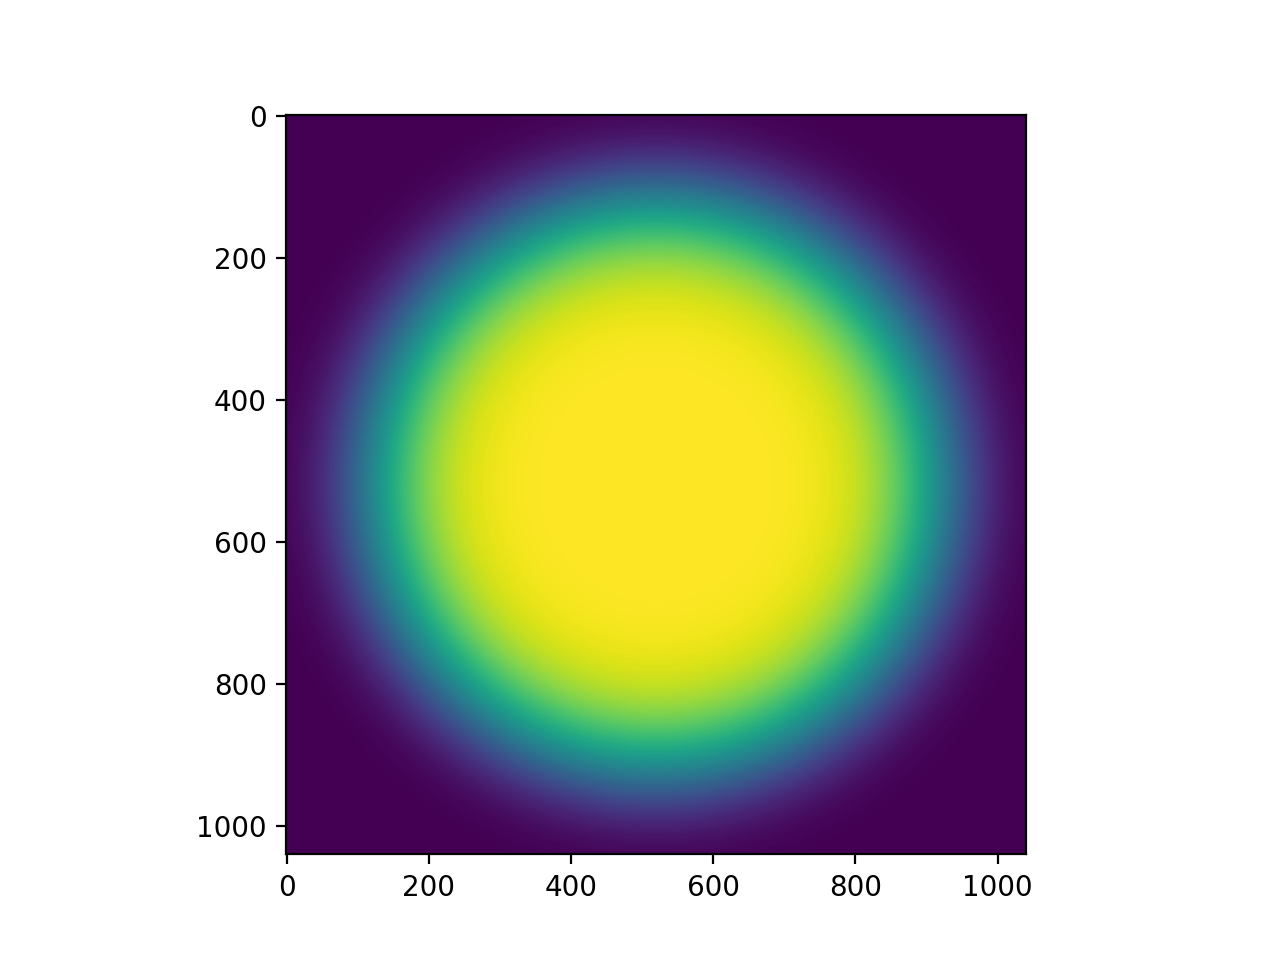

(1040, 1040, 41)


In [3]:
fig,ax = plt.subplots()
guess = np.ones_like(region[0])*window
guess = np.pad(guess,((pad,pad),(pad,pad)))

guess = guess[None,:,:]

guess = np.resize(guess,(41,guess.shape[-2],guess.shape[-1]))
guess = np.moveaxis(guess,0,-1)
test = ax.imshow(guess[:,:,2])

# guess = guess[None,None,:,:,:]
print(guess.shape)




<IPython.core.display.Javascript object>


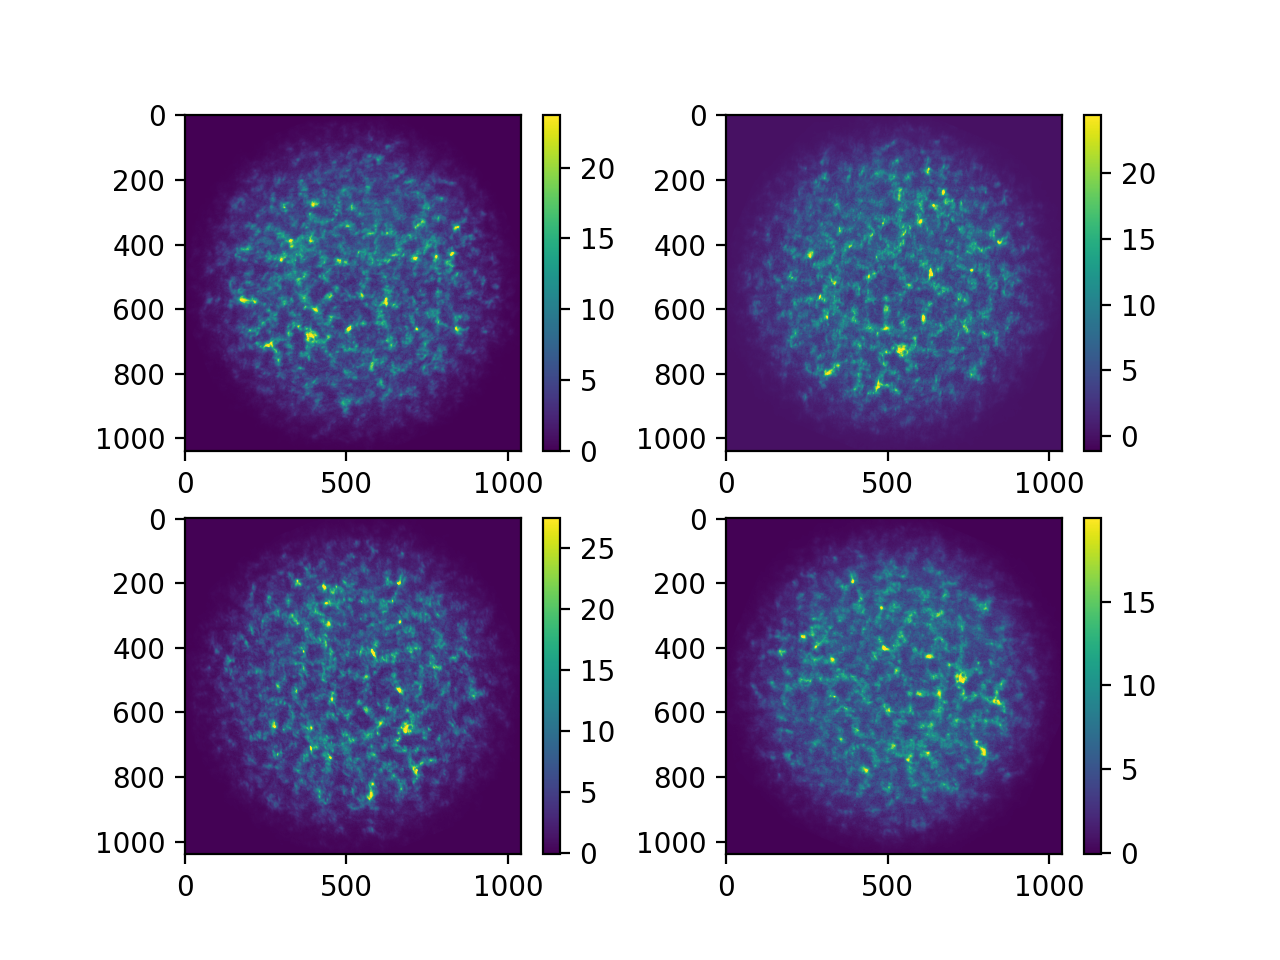

(1, 4, 1040, 1040, 1)


In [4]:
rotation_kwargs = {
    'reshape': False,
    'prefilter': False,
    'order': 1,
    'mode': 'constant',
    'cval': 0,
}

angles = (np.arange(4)*45 - 22.5 + 45 -90)* u.deg
# angles = (np.arange(4)*90)* u.deg

fig,ax = plt.subplots(2,2)
j = np.array([0,1,0,1])
projections = []
for i,angle in enumerate(angles):
    projection = scipy.ndimage.rotate(np.pad(region[i]*window,((pad,pad),(pad,pad))),angle,**rotation_kwargs)
    im = ax[i//2,j[i]].imshow(projection,vmax = np.percentile(projection,99.9))
    projections.append(projection)
    fig.colorbar(im, ax = ax[i//2,j[i]])

projections = np.array(projections)
projections = projections[None,:,:,:,None]
print(projections.shape)

projections[projections<0] = 0



In [5]:

spectral_order = 1
mart_obj = mart.MART(
    use_maximize=True,
    use_filter=True,
    use_lgof = False,
    anti_aliasing=None,
    max_multiplicative_iteration=50,
    max_filtering_iterations=25,
    track_cube_history='filter',
    contrast_exponent=.2,
    rotation_kwargs=rotation_kwargs
)

ref_wavelen = 1+guess.shape[-1] // 2
recovered = mart_obj(
    projections,
    angles,
    np.array(spectral_order),
    cube_offset_x=ref_wavelen,
    # region.shape,
    cube_guess=guess
)

13.622683039355492
correcting


/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/simple_mart.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio = projection / test_projection
/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/forward.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shifted_projection[out_sl] = projection[in_sl]
/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/forward.py:173: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  backp

2.6617590317328528
correcting


/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/simple_mart.py:145: RuntimeWarning: divide by zero encountered in true_divide
  ratio = projection / test_projection


0.8084717120061252
0.9082783136376132
0.6413068581417186
0.603300840782057
0.8084717120061252
0.9082783136376132
0.650528773130293
0.6177075037131518
0.8011283856011491
0.9177864507591743
0.6647765196057202
0.6337084317487478
0.8029158000664804
0.9352257233538468
0.6883125493858891
0.658879480800341
0.8151662987281493
0.9615693058696984
0.7230977774081013
0.6953985651426774
0.8386712424094642
0.9973266045646741
0.771492384071462
0.7449921998264256
0.8746787373789326
1.0435646808064398
correcting
0.1891435953771289
0.1969668786905324
0.3137774693093523
0.2540568920212934
0.22328887423592264
0.23323589357731658
0.32808859875208507
0.29147683355669235
0.2733745982701796
0.2861780382893732
0.35776090223069423
0.3339376829979639
0.3419063878739308
0.3582466081944425
0.40495664025874223
0.3880324212145617
0.4319377611712889
0.45272923390439057
0.4726741282633413
0.457308348553699
0.5473815525767516
0.5737696390543563
0.5646312672183594
0.5456123441411181
0.6932080866804442
0.7265606254138445

In [6]:
image_wcs = ov.observation[seq,0,event[0],event[1]].wcs.dropaxis(-1)
image_wcs = image_wcs.dropaxis(-1)
print(image_wcs)

header = image_wcs.to_header()
print(header)
header['ctype1'] = 'Solar Y'
header['ctype2'] = 'Solar X'
header['naxis'] = 3
header['ctype3'] = 'pix'
header['crval3'] = 0
header['crpix3'] = ref_wavelen
header['cdelt3'] = 1
header['naxis3'] = guess.shape[-1]

result_wcs = wcs.WCS(header)
result_wcs = result_wcs.swapaxes(-1,0)
result_wcs.array_shape = guess.shape
print(result_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 533.5  588.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  
NAXIS : 1040  1040
WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =                533.5 / Pixel coordinate of reference point            CRPIX2  =                588.5 / Pixel coordinate of reference point            CDELT1  =  0.00016666666666667 / [deg] Coordinate increment at reference point  CDELT2  =  0.00016666666666667 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        CTYPE2  = 'HPLT-TAN'           / Coordinate type codegnomonic projection        CRVAL1  =                  0.0 / [deg] Coordina

<IPython.core.display.Javascript object>


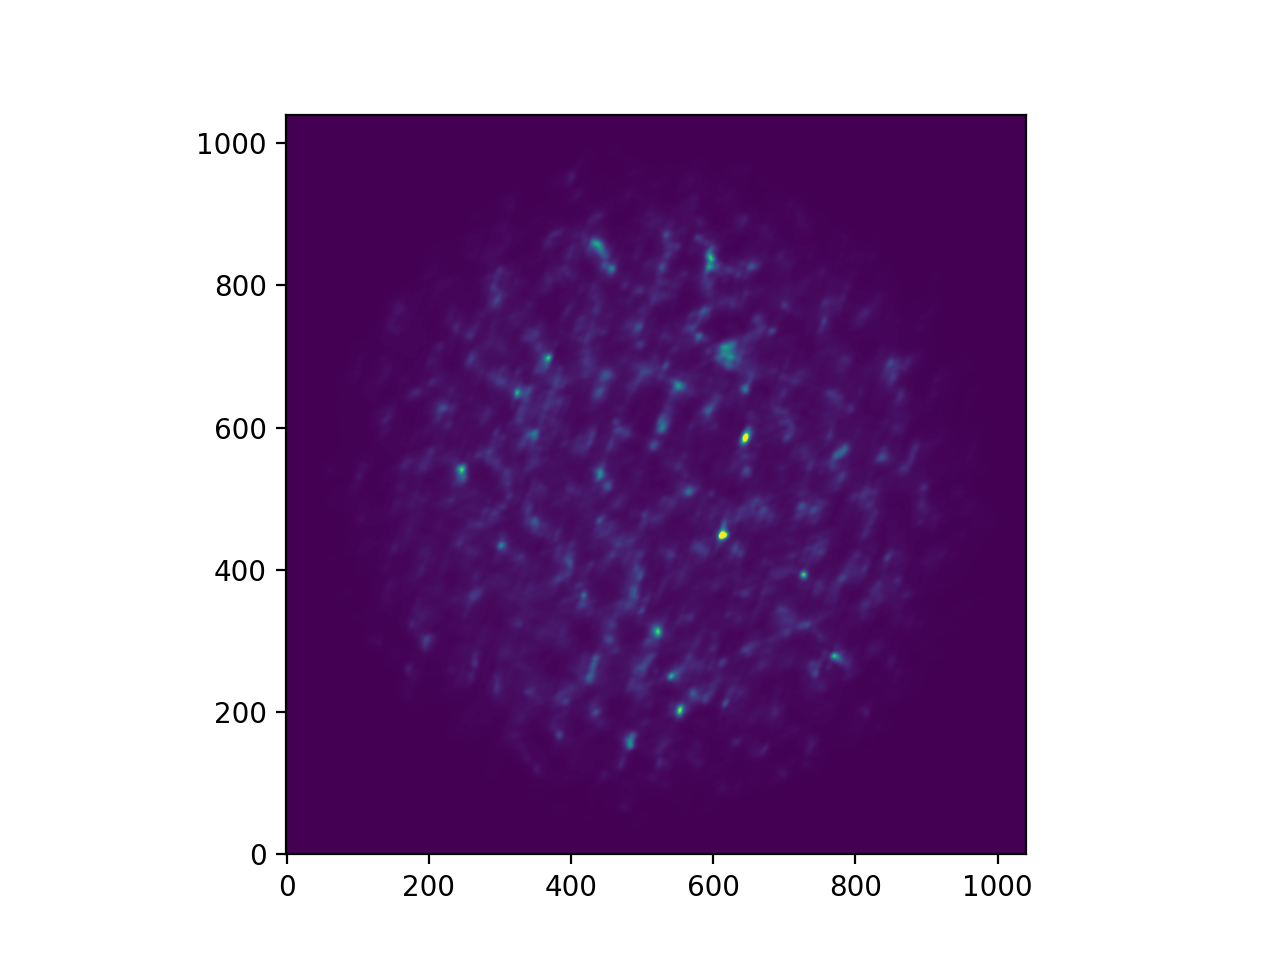

In [7]:
display_cube = np.squeeze(recovered.cube_history[-5])

fig,ax = plt.subplots()
ax.imshow(display_cube.sum(-1),
          vmax = np.percentile(display_cube.sum(-1),99.99),
          origin='lower')


<IPython.core.display.Javascript object>


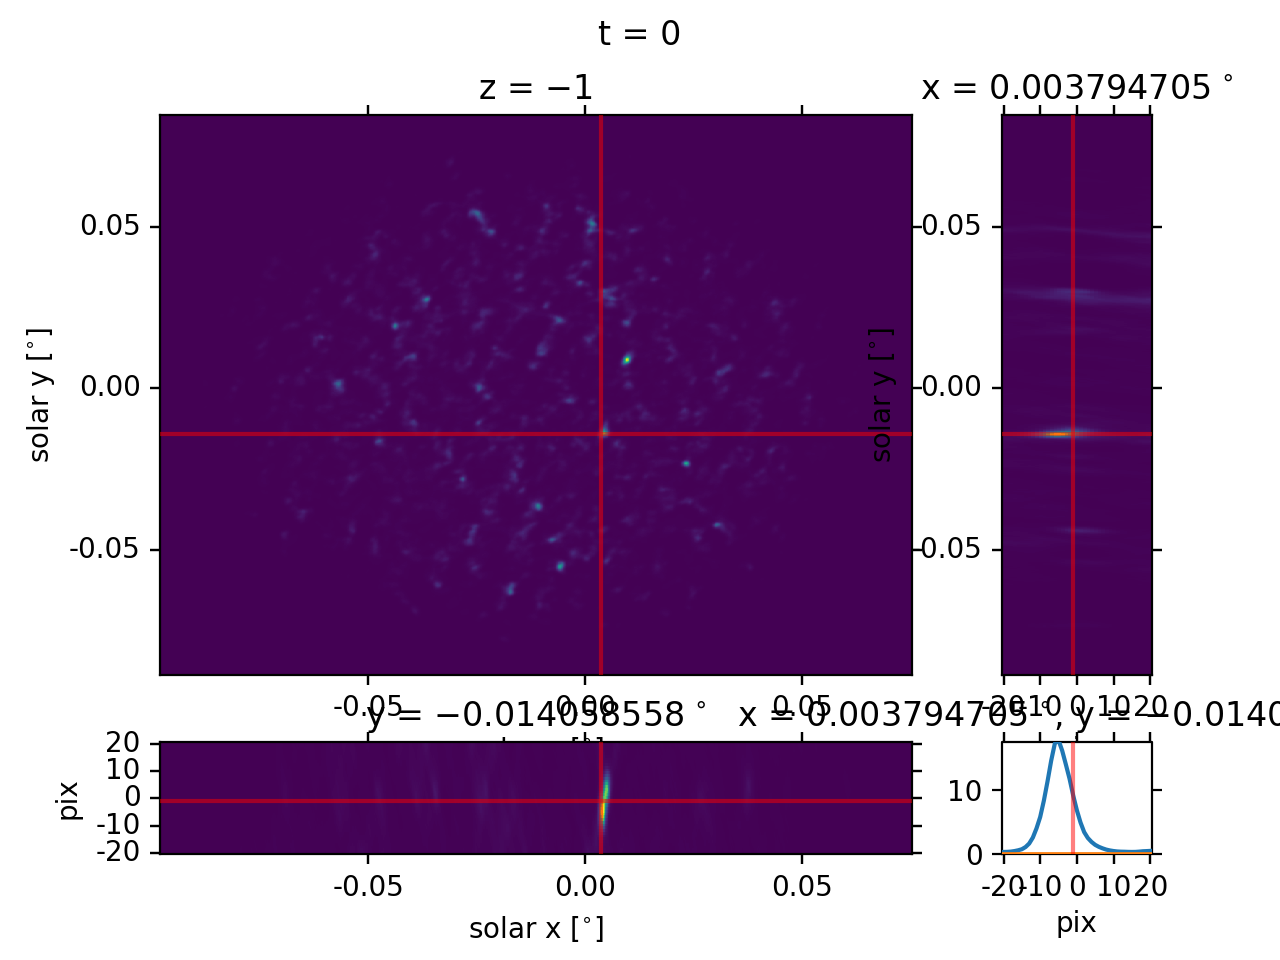

In [8]:
slicer = hypercube_slicer.HypercubeSlicer(display_cube[None,...],[result_wcs],width_ratios=(5, 1),
                height_ratios=(5, 1))




In [9]:
import kgpy.moment

total_intensity = np.sum(display_cube,axis = -1)
threshold = np.percentile(total_intensity,95)

shifts = np.squeeze(kgpy.moment.percentile.shift(display_cube))
shifts -= 21
print(np.nanmin(shifts))
shifts[total_intensity < threshold] = 0

-20.999748503356592


/media/jake/Media/Documents/Research/Kankelborg Group/kgpy/kgpy/moment/percentile.py:35: RuntimeWarning: invalid value encountered in true_divide
  x = (y - y0) / (y1 - y0) * (x1 - x0) + x0


<IPython.core.display.Javascript object>


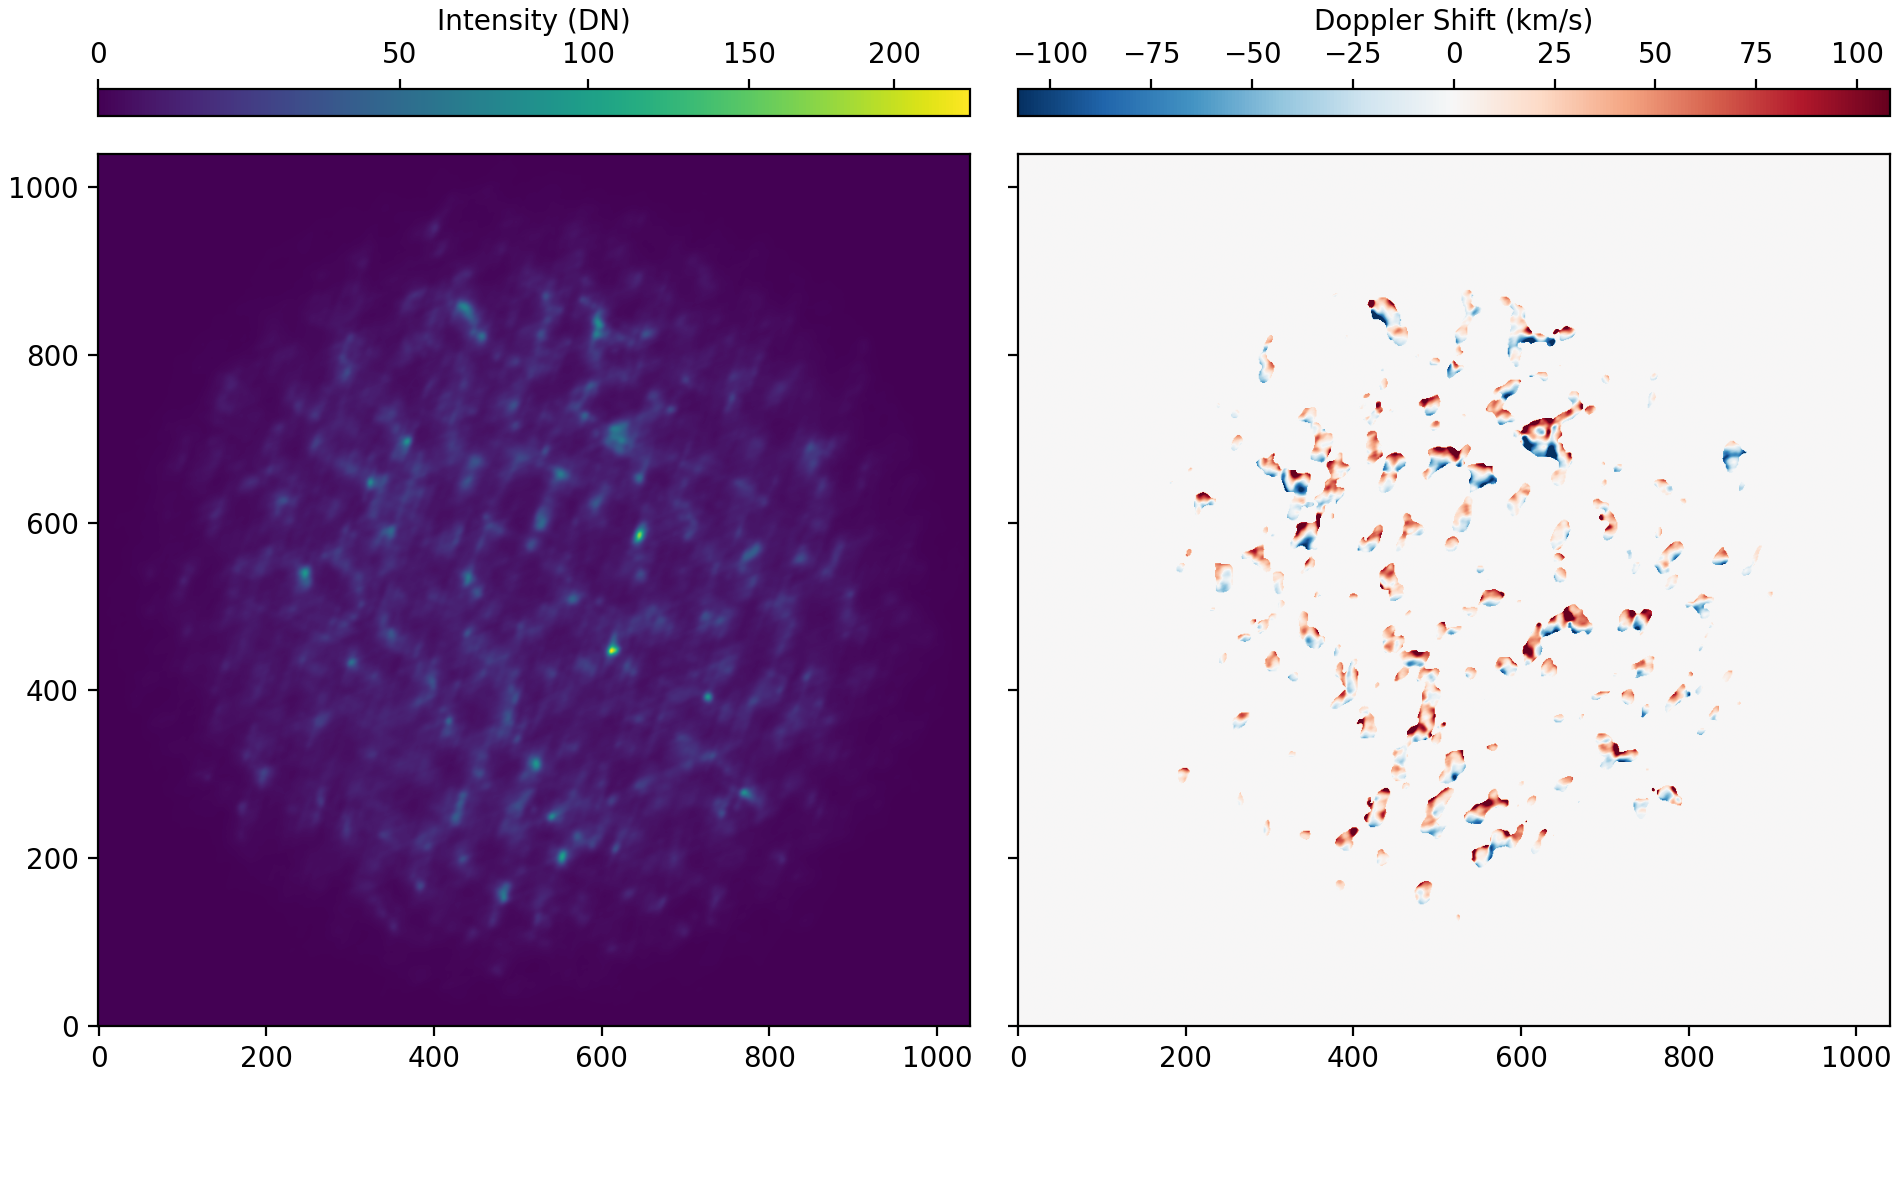

In [10]:
import matplotlib.colors

vel_per_pixel = 18

fig,ax = plt.subplots(ncols = 2,sharey = True, sharex = True,
#                       subplot_kw = {'projection':result_wcs.dropaxis(0)},
                      constrained_layout = True, figsize = (9.5, 6)
                    )

im2 = ax[0].imshow(total_intensity,norm = matplotlib.colors.PowerNorm(.7), origin = 'lower')
fig.colorbar(im2,ax = ax[0],location = 'top', label = 'Intensity (DN)')
im = ax[1].imshow(-shifts*vel_per_pixel,cmap = 'RdBu_r',vmin = -6*vel_per_pixel, vmax = 6*vel_per_pixel, origin = 'lower')
fig.colorbar(im,ax = ax[1],location = 'top', label = 'Doppler Shift (km/s)')



In [11]:
fig.savefig('Level_3_DopplerMap_'+str(seq)+'.pdf')